# Gibson Assembly from the original publication
> Visit the full library documentation [here](https://pydna-group.github.io/pydna/)

This example showcases a workflow of modelling Gibson assembly to clone gene fragments into plasmids for synthetic biology. The biological example is sourced [here](https://www.nature.com/articles/nmeth.1318#MOESM319), from the original Gibson assembly paper. This example constructs a synthetic pCC1BAC plasmid by joining sequence fragments from Ruminiclostridium (Clostridium) cellulolyticum. The R. cellulolyticum fragments joined are termed F1, F2, and F3, as in the paper.

Source files can be found alongside this notebook, if you would like to follow along. Annotations are made alongside the code to describe key steps.


<a target="_blank" href="https://colab.research.google.com/github/pydna-group/pydna/blob/master/docs/notebooks/Example_Gibson.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
%%capture
# Install pydna (only when running on Colab)
import sys
if 'google.colab' in sys.modules:
    %pip install pydna[clipboard,download,express,gel]
    !curl -LO "https://github.com/pydna-group/pydna/raw/master/docs/notebooks/pCC1BAC.gb"


In [ ]:
# Importing all necessary classes and methods

from pydna.parsers import parse
from pydna.tm import tm_default
from pydna.amplify import pcr
from pydna.dseqrecord import Dseqrecord
from pydna.assembly2 import gibson_assembly
from pydna.genbank import Genbank
from pydna.gel import gel
from pydna.ladders import GeneRuler_1kb_plus


In [ ]:
# Reading the R. cellulolyticum genome from GenBank
gb = Genbank("example@example.com")
genome = gb.nucleotide("CP001348.1")
# Print the info of the genome
genome.annotations

{'molecule_type': 'DNA',
 'topology': 'circular',
 'data_file_division': 'BCT',
 'date': '25-AUG-2017',
 'accessions': ['CP001348', 'AAVC01000000', 'AAVC01000001-AAVC01000121'],
 'sequence_version': 1,
 'keywords': [''],
 'source': 'Ruminiclostridium cellulolyticum H10',
 'organism': 'Ruminiclostridium cellulolyticum H10',
 'taxonomy': ['Bacteria',
  'Bacillati',
  'Bacillota',
  'Clostridia',
  'Eubacteriales',
  'Oscillospiraceae',
  'Ruminiclostridium'],
 'references': [Reference(title='Complete sequence of Clostridium cellulolyticum H10', ...),
  Reference(title='Direct Submission', ...)],
 'comment': 'URL -- http://www.jgi.doe.gov\nJGI Project ID: 4002584\nSource DNA and bacteria available from Jizhong Zhou\n(jzhou@rccc.ou.edu)\nContacts: Jizhong Zhou (jzhou@rccc.ou.edu)\n          David Bruce (microbe@cuba.jgi-psf.org)\nAnnotation done by JGI-ORNL and JGI-PGF\nFinishing done by JGI-LANL\nFinished microbial genomes have been curated to close all gaps with\ngreater than 98% coverag

In [ ]:
# Reading the plasmid
vector = parse("./pCC1BAC.gb")[0]
vector.annotations

/Users/manu/Documents/OpenSource/pydna/.venv/lib/python3.12/site-packages/Bio/GenBank/Scanner.py:1537: BiopythonParserWarning: Attempting to parse malformed locus line:
'LOCUS       Exported                8139 bp DNA     circular SYN 29-AUG-2024\n'
Found locus 'Exported' size '8139' residue_type 'DNA'
Some fields may be wrong.
  warnings.warn(


{'molecule_type': 'DNA',
 'topology': 'circular',
 'data_file_division': 'SYN',
 'date': '29-AUG-2024',
 'accessions': ['.'],
 'keywords': [''],
 'source': 'synthetic DNA construct',
 'organism': 'synthetic DNA construct',
 'taxonomy': [],
 'references': [Reference(title='Direct Submission', ...),
  Reference(title='Direct Submission', ...),
  Reference(title='Direct Submission', ...),
  Reference(title='Direct Submission', ...)],
 'comment': 'SGRef: number: 1; type: "Journal Article"; journalName: "Submitted\n(23-AUG-2007) 726 Post Road, Madison, WI 53713, USA"\nSGRef: number: 2; type: "Journal Article"\nSGRef: number: 3; type: "Journal Article"'}

In [ ]:
# Importing pre-designed primers for the PylRS insert fragment. 

F1_For = "GCAGCTTCAAGTCCTGCAAACAAGGTGTACCAGGATCGTT"
F1_Rev = "GATTTCAGTGTAGTTAGGGCCAGTTGAATTCAAACCTGCC"
F2_For = "GGCAGGTTTGAATTCAACTGGCCCTAACTACACTGAAATC"
F2_Rev = "CTTGGTGCCATCAGCATTGTTCTCTGTACCGCCCACTGTC"
F3_For = "GACAGTGGGCGGTACAGAGAACAATGCTGATGGCACCAAG"
F3_Rev = "CAGTTGAATAATCATGTGTTCCTGCGGCAAATGCAGTACC"
BACF1_For = "AACGATCCTGGTACACCTTGTTTGCAGGACTTGAAGCTGCgcggccgcgatcctctagagtcgacctg"
BACF3_Rev = "GGTACTGCATTTGCCGCAGGAACACATGATTATTCAACTGgcggccgccgggtaccgagctcgaattc"

In [ ]:
# Getting the PCR products from the genome (might take a while since the genome is large)

pcr_product_F1 = pcr(F1_For, F1_Rev, genome, limit=20)
pcr_product_F2 = pcr(F2_For, F2_Rev, genome, limit=20)
pcr_product_F3 = pcr(F3_For, F3_Rev, genome, limit=20)
pcr_product_BAC = pcr(BACF1_For, BACF3_Rev, vector, limit=20)

# Printing out the PCR fragment sizes
print(len(pcr_product_F1))
print(len(pcr_product_F2))
print(len(pcr_product_F3))
print(len(pcr_product_BAC))


5210
5384
5172
8221


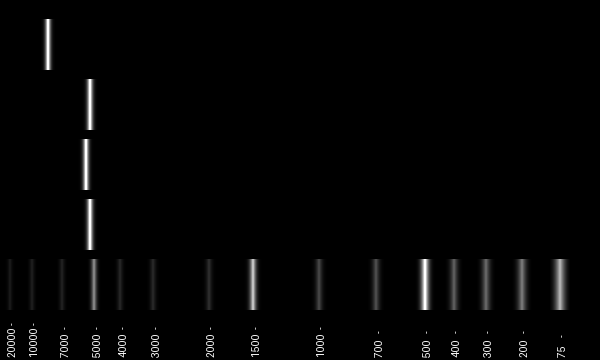

In [ ]:
# Making a gel to show the PCR products
im = gel(
    [
        GeneRuler_1kb_plus,
        [pcr_product_F1],
        [pcr_product_F2],
        [pcr_product_F3],
        [pcr_product_BAC],
    ]
)
im.rotate(90, expand=1)

In [ ]:
# Performing the Gibson Assembly. Note that the assembly class parameters should be given as a list.

products = gibson_assembly([pcr_product_F1,pcr_product_F2,pcr_product_F3,pcr_product_BAC])

# Printing out the Gibson Assembly product
print(products[0])

Dseqrecord
circular: True
size: 23827
ID: id
Name: name
Description: description
Number of features: 42
/molecule_type=DNA
Dseq(o23827)
GCAG..ccgc
CGTC..ggcg
